# Comparing grbsens and ctools

### Things to check
- ✅ Sensitivity vs. Time curves (compare sensitivities)
- ✅ Compare power law used in each time bin
- Compare observation times of GRBs
- Check prod5-v0.2 in gammapy

### Units
- FITS GRB files
  - time [s]
  - energy [GeV]
  - spectral flux [ph/cm2/s/GeV]
- ctools grbsens outputs
  - prefactor [ph/cm2/s/MeV]
  - pivot energy [MeV]
  - emin/emax [TeV]
  - photon flux [ph/cm2/s]
  - sensitivity [erg/cm2/s]
- gammapy SensitivityEstimator outputs
  - e2dnde [erg/cm2/s]

### Imports

In [1]:
from pathlib import Path

import astropy.units as u

# %matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from gravitational_wave_toy.ctairf import IRFHouse
from gravitational_wave_toy.observe import GRB
from gravitational_wave_toy.sensitivity import (
    SensitivityCtools,
    SensitivityGammapy,
)
from gravitational_wave_toy.util import suppress_warnings_and_logs


import grbsens_comparison as grbc

sns.set()

# set logging level to debug
# logging.basicConfig(level=logging.DEBUG)

### Example: Load in an IRF (South Alpha z20 prod5-v0.1)

In [2]:
house = IRFHouse(base_directory="/Users/jarred/Documents/Work/CTA-IRFs")

site = "south"
configuration = "alpha"
zenith = 20

irf = house.get_irf(
    site=site,
    configuration=configuration,
    zenith=zenith,
    duration=1800,
    azimuth="average",
    version="prod5-v0.1" if configuration == "alpha" else "prod3b-v2",
)

### Example: Load in ctools sensitivity
- direct from file, no fitting atm

In [ ]:
grbsens_dir = Path(
    f"/Users/jarred/Documents/Work/gravitational_wave_toy/CTA_sensitivity/grbsens_output_v3_Sep_2022/{configuration}_configuration"
)
grbsens_file = (
    grbsens_dir
    / f"grbsens-5.0sigma_t1s-t16384s_irf-{irf.site.name.capitalize()}_z{irf.zenith}_0.5h.txt"
)
cols = [
    "duration",
    "crab_flux",
    "photon_flux",
    "energy_flux",
    "sensitivity",
]

ctools_curve = pd.read_csv(grbsens_file, sep="\t", comment="#", names=cols)

# Cross-check all IRFs and zeniths
Note: Previous tests [see grbsens-comparison-beta.ipynb] shows that the gammapy sensitivity estimation function is completely insensitive to the amplitude (normalization) as the output is exactly the same as using a fixed power law

2023-11-28 13:32:55,947 - grbsens_comparison - INFO - Starting comparison of all IRFs


2023-11-28 13:32:55,951 - grbsens_comparison - INFO - Processing IRF: south alpha
Processing IRF: prod5-v0.1 Site.south 20deg 16384s: 100%|██████████| 15/15 [00:03<00:00,  4.88it/s]
Processing IRF: prod5-v0.1 Site.south 40deg 16384s: 100%|██████████| 15/15 [00:03<00:00,  4.58it/s]
Processing IRF: prod5-v0.1 Site.south 60deg 16384s: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]


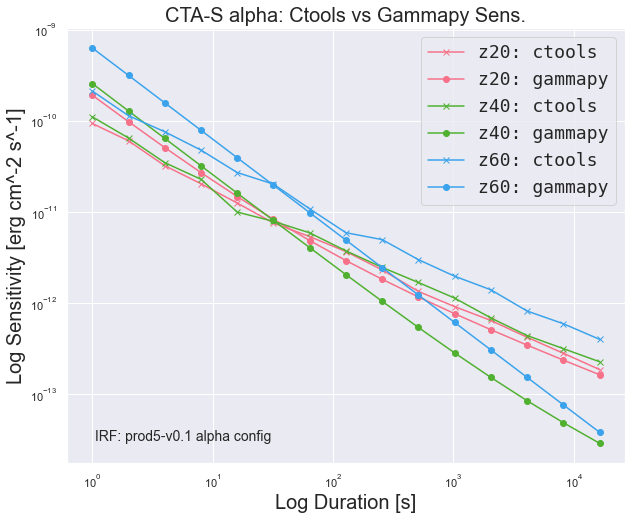

2023-11-28 13:33:06,932 - grbsens_comparison - INFO - Processing IRF: south omega
Processing IRF: prod3b-v2 Site.south 20deg 16384s: 100%|██████████| 15/15 [00:01<00:00,  7.72it/s]
Processing IRF: prod3b-v2 Site.south 40deg 16384s: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s]
Processing IRF: prod3b-v2 Site.south 60deg 16384s: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s]


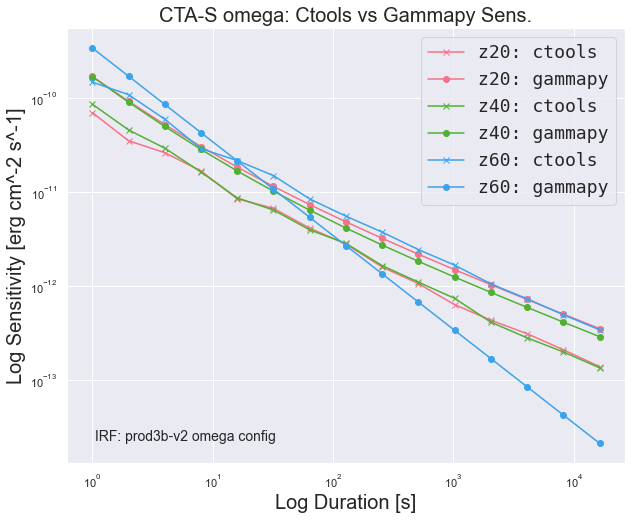

2023-11-28 13:33:13,993 - grbsens_comparison - INFO - Processing IRF: north alpha
Processing IRF: prod5-v0.1 Site.north 20deg 16384s: 100%|██████████| 15/15 [00:02<00:00,  5.60it/s]
Processing IRF: prod5-v0.1 Site.north 40deg 16384s: 100%|██████████| 15/15 [00:03<00:00,  4.76it/s]
Processing IRF: prod5-v0.1 Site.north 60deg 16384s: 100%|██████████| 14/14 [00:03<00:00,  3.76it/s]


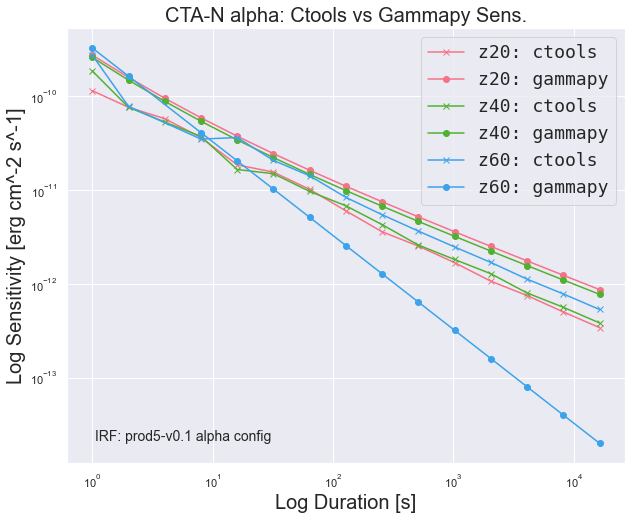

2023-11-28 13:33:23,965 - grbsens_comparison - INFO - Processing IRF: north omega
Processing IRF: prod3b-v2 Site.north 20deg 16384s: 100%|██████████| 15/15 [00:01<00:00,  8.16it/s]
Processing IRF: prod3b-v2 Site.north 40deg 16384s: 100%|██████████| 15/15 [00:01<00:00,  7.82it/s]
Processing IRF: prod3b-v2 Site.north 60deg 16384s: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s]


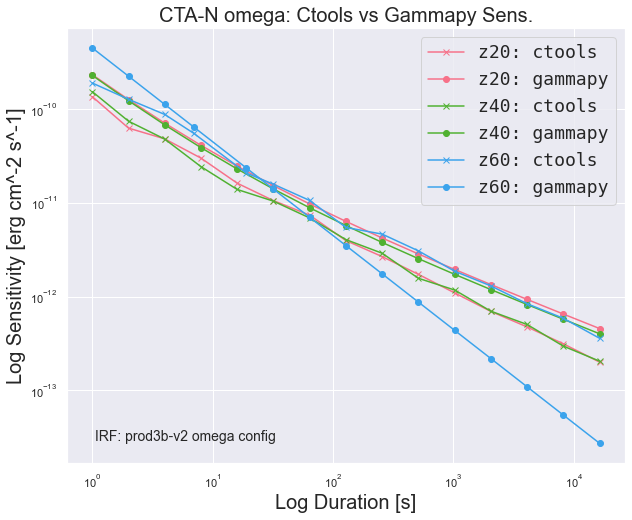

In [174]:
grbc.compare_all_IRFs()

# Compare observation times

In [3]:
# get sensitivities

# GAMMAPY
house = IRFHouse(base_directory="/Users/jarred/Documents/Work/CTA-IRFs")

site = "south"
configuration = "alpha"
zenith = 20
min_energy = 0.03 * u.TeV
max_energy = 10 * u.TeV

irf = house.get_irf(
    site=site,
    configuration=configuration,
    zenith=zenith,
    duration=1800,
    azimuth="average",
    version="prod5-v0.1" if configuration == "alpha" else "prod3b-v2",
)

gammapy_sens = SensitivityGammapy(
    irf, observatory="cta_south", radius=3.0 * u.deg, min_energy=min_energy, max_energy=max_energy
)

# CTOOLS
grbsens_dir = Path(
    f"/Users/jarred/Documents/Work/gravitational_wave_toy/CTA_sensitivity/grbsens_output_v3_Sep_2022/{configuration}_configuration"
)
grbsens_file = (
    grbsens_dir
    / f"grbsens-5.0sigma_t1s-t16384s_irf-{irf.site.name.capitalize()}_z{irf.zenith}_0.5h.txt"
)

ctools_sens = SensitivityCtools(
    grbsens_file, min_energy=0.03 * u.TeV, max_energy=10 * u.TeV
)

In [4]:
# pick a few GRBs
grb_dir = "/Users/jarred/Downloads/TeV Catalog O5"

# get all files with pathlib
grb_files = list(Path(grb_dir).glob("*.fits"))

# grb_ids = [1, 2, 3, 5, 8, 13, 31]

grb_id = 0

GRB ID 0 Spectral Evolution


/Users/jarred/Documents/Work/gravitational_wave_toy/gravitational_wave_toy/observe.py:96: RuntimeWarning: divide by zero encountered in log10
  np.log10(self.SpectralGrid(points)).reshape(resolution + 1, resolution + 1),


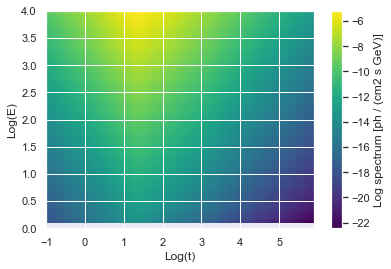

In [6]:
grb = GRB(filepath=grb_files[grb_id], min_energy=0.03 * u.TeV, max_energy=10 * u.TeV)
print(f"GRB ID {grb_id} Spectral Evolution")
grb.show_spectral_pattern()

In [7]:
gammapy_sens.get_sensitivity_curve(grb)

Processing GRB: 525 43200.00 s s: 100%|██████████| 16/16 [00:03<00:00,  4.52it/s]


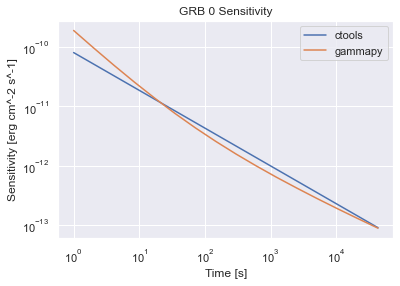

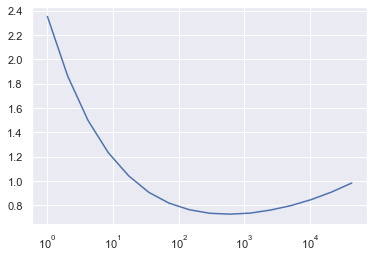

In [51]:
times = gammapy_sens.times
plt.loglog(times, [ctools_sens.get(t, mode="sensitivity").value for t in times], label="ctools")
plt.loglog(times, [gammapy_sens.get(t).value for t in times], label="gammapy")
plt.title(f"GRB {grb_id} Sensitivity")
plt.xlabel("Time [s]")
plt.ylabel("Sensitivity [erg cm^-2 s^-1]")
plt.legend()
plt.show()

# plot ratio between two curves
plt.semilogx(
    times,
    [
        gammapy_sens.get(t).value / ctools_sens.get(t, mode="sensitivity").value
        for t in times
    ],
)
plt.show()

In [58]:
grb.observe(
    ctools_sens,
    start_time=30 * u.s,
)

{'filepath': PosixPath('/Users/jarred/Downloads/TeV Catalog O5/catO5_525.fits'),
 'min_energy': <Quantity 30. GeV>,
 'max_energy': <Quantity 10000. GeV>,
 'seen': True,
 'obs_time': <Quantity 0.65917969 s>,
 'start_time': <Quantity 30. s>,
 'end_time': <Quantity 30.65917969 s>,
 'error_message': '',
 'id': 525,
 'long': 3.122,
 'lat': -0.895,
 'eiso': 7.17e+49,
 'dist': 850000.0,
 'angle': 25.544,
 '_num_iters': 0,
 '_last_guess': <Quantity 43230. s>}

In [59]:
grb.observe(
    gammapy_sens,
    start_time=30 * u.s,
)

/Users/jarred/Documents/Work/gravitational_wave_toy/gravitational_wave_toy/observe.py:289: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fluence = integrate.quad(


{'filepath': PosixPath('/Users/jarred/Downloads/TeV Catalog O5/catO5_525.fits'),
 'min_energy': <Quantity 30. GeV>,
 'max_energy': <Quantity 10000. GeV>,
 'seen': True,
 'obs_time': <Quantity 0.65917969 s>,
 'start_time': <Quantity 30. s>,
 'end_time': <Quantity 30.65917969 s>,
 'error_message': '',
 'id': 525,
 'long': 3.122,
 'lat': -0.895,
 'eiso': 7.17e+49,
 'dist': 850000.0,
 'angle': 25.544,
 '_num_iters': 0,
 '_last_guess': <Quantity 43230. s>}

In [60]:
ctools_results = []
gammapy_results = []
difference = []

t = 30 * u.s
for f in tqdm(grb_files[30:60]):
    grb = GRB(filepath=f, min_energy=0.03 * u.TeV, max_energy=10 * u.TeV)
    gammapy_sens.get_sensitivity_curve(grb)
    cr = grb.observe(
        ctools_sens,
        start_time=t,
    )
    gr = grb.observe(
        gammapy_sens,
        start_time=t,
    )
    
    if cr["obs_time"] < 0 or gr["obs_time"] < 0:
        if cr["obs_time"] < 0:
            print(f"ctools:  GRB no. {grb.id} not detected")
        if gr["obs_time"] < 0:
            print(f"gammapy: GRB no. {grb.id} not detected")
        continue
    else:
        ctools_results.append(cr)
        gammapy_results.append(gr)
        difference.append(cr["obs_time"] - gr["obs_time"])

Processing GRB: 1878 43200.00 s s: 100%|██████████| 16/16 [00:03<00:00,  4.68it/s]
/Users/jarred/Documents/Work/gravitational_wave_toy/gravitational_wave_toy/observe.py:289: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fluence = integrate.quad(
Processing GRB: 1252 43200.00 s s: 100%|██████████| 16/16 [00:03<00:00,  4.80it/s]
/Users/jarred/Documents/Work/gravitational_wave_toy/gravitational_wave_toy/observe.py:289: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integran

ctools:  GRB no. 12 not detected
gammapy: GRB no. 12 not detected


 20%|██        | 6/30 [01:10<03:36,  9.02s/it]

ctools:  GRB no. 1317 not detected
gammapy: GRB no. 1317 not detected


 23%|██▎       | 7/30 [01:15<02:58,  7.77s/it]

ctools:  GRB no. 1747 not detected


 27%|██▋       | 8/30 [01:18<02:20,  6.37s/it]

ctools:  GRB no. 564 not detected
gammapy: GRB no. 564 not detected


 30%|███       | 9/30 [01:22<01:56,  5.54s/it]

ctools:  GRB no. 1028 not detected
gammapy: GRB no. 1028 not detected


 37%|███▋      | 11/30 [01:31<01:34,  4.95s/it]

ctools:  GRB no. 1182 not detected
gammapy: GRB no. 1182 not detected


 43%|████▎     | 13/30 [01:41<01:19,  4.67s/it]

ctools:  GRB no. 837 not detected
gammapy: GRB no. 837 not detected


 47%|████▋     | 14/30 [01:44<01:09,  4.33s/it]

ctools:  GRB no. 1881 not detected
gammapy: GRB no. 1881 not detected


 50%|█████     | 15/30 [01:48<01:00,  4.04s/it]

ctools:  GRB no. 2254 not detected
gammapy: GRB no. 2254 not detected


 53%|█████▎    | 16/30 [01:52<01:00,  4.30s/it]

ctools:  GRB no. 972 not detected


 57%|█████▋    | 17/30 [01:56<00:52,  4.06s/it]

ctools:  GRB no. 421 not detected
gammapy: GRB no. 421 not detected


 60%|██████    | 18/30 [02:01<00:50,  4.25s/it]

ctools:  GRB no. 1497 not detected


 63%|██████▎   | 19/30 [02:04<00:44,  4.02s/it]

ctools:  GRB no. 2038 not detected
gammapy: GRB no. 2038 not detected


 67%|██████▋   | 20/30 [02:08<00:38,  3.85s/it]

ctools:  GRB no. 2192 not detected
gammapy: GRB no. 2192 not detected


 70%|███████   | 21/30 [02:11<00:33,  3.71s/it]

ctools:  GRB no. 1614 not detected
gammapy: GRB no. 1614 not detected


Processing GRB: 358 43200.00 s s: 100%|██████████| 16/16 [00:03<00:00,  4.73it/s]
/Users/jarred/Documents/Work/gravitational_wave_toy/gravitational_wave_toy/observe.py:289: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fluence = integrate.quad(
/Users/jarred/Documents/Work/gravitational_wave_toy/gravitational_wave_toy/observe.py:289: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  fluence = integrate.quad(
 77%|███████▋  | 23/30 [02:31<00:43,  6.27s/it]

ctools:  GRB no. 1244 not detected
gammapy: GRB no. 1244 not detected


 80%|████████  | 24/30 [02:34<00:32,  5.44s/it]

ctools:  GRB no. 708 not detected
gammapy: GRB no. 708 not detected


 83%|████████▎ | 25/30 [02:38<00:24,  4.84s/it]

ctools:  GRB no. 1751 not detected
gammapy: GRB no. 1751 not detected


 87%|████████▋ | 26/30 [02:41<00:17,  4.43s/it]

ctools:  GRB no. 0 not detected
gammapy: GRB no. 0 not detected


 90%|█████████ | 27/30 [02:45<00:12,  4.17s/it]

ctools:  GRB no. 1301 not detected
gammapy: GRB no. 1301 not detected


Processing GRB: 2203 43200.00 s s: 100%|██████████| 16/16 [00:03<00:00,  4.79it/s]
/Users/jarred/Documents/Work/gravitational_wave_toy/gravitational_wave_toy/observe.py:289: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  fluence = integrate.quad(
Processing GRB: 499 43200.00 s s: 100%|██████████| 16/16 [00:03<00:00,  4.75it/s]
/Users/jarred/Documents/Work/gravitational_wave_toy/gravitational_wave_toy/observe.py:289: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand

In [56]:
difference

[<Quantity 0. s>,
 <Quantity 0. s>,
 <Quantity 0. s>,
 <Quantity 0. s>,
 <Quantity 1049.90844727 s>,
 <Quantity 489.44091797 s>,
 <Quantity 0. s>,
 <Quantity 0. s>,
 <Quantity 1844.71435547 s>,
 <Quantity 0. s>]

In [61]:
for gg, cc in zip(gammapy_results, ctools_results):
    print(f"gammapy: {gg['obs_time']}, ctools: {cc['obs_time']}")

gammapy: 0.6591796875 s, ctools: 0.6591796875 s
gammapy: 0.6591796875 s, ctools: 0.6591796875 s
gammapy: 0.6591796875 s, ctools: 0.6591796875 s
gammapy: 0.6591796875 s, ctools: 0.6591796875 s
gammapy: 798.2666015625 s, ctools: 1870.42236328125 s
gammapy: 433.0810546875 s, ctools: 961.7431640625 s
gammapy: 0.6591796875 s, ctools: 0.6591796875 s
gammapy: 0.6591796875 s, ctools: 0.6591796875 s
gammapy: 1224.42626953125 s, ctools: 3111.9873046875 s
gammapy: 0.6591796875 s, ctools: 0.6591796875 s


In [10]:
gammapy_sens._sensitivity_curve.value.tolist()

[1.8790939877263963e-10,
 9.46405712612739e-11,
 4.8444122787385255e-11,
 2.5358147036159267e-11,
 1.3654340695902168e-11,
 7.546826655693233e-12,
 4.331090856869293e-12,
 2.5732791226856767e-12,
 1.5757240795518689e-12,
 9.92841772593354e-13,
 6.39349948585403e-13,
 4.207841560865357e-13,
 2.805799482189946e-13,
 1.896153742563485e-13,
 1.2950377531912919e-13,
 8.920809859170521e-14]